## Загрузка всех необходимых пакетов


In [533]:
## Базовые пакеты для работы с датасетом
import pyreadstat
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV

from statsmodels.multivariate.factor import Factor

import scipy.stats as stats
from scipy.stats import mannwhitneyu as U

import seaborn as sns

## Чтение данных

In [536]:
# Чтение данных
df, meta = pyreadstat.read_sav(r"C:\Users\79118\OneDrive\Рабочий стол\00РЦ\Архивы проектов [подготовленные]\Мониторинг здоровья 2024\МЗ_универсанты_перекодир_сон.sav", apply_value_formats=True)
df.shape

(2083, 512)

## Необходимые для работы функции

In [538]:
# Функция для рчной перекодировки данных

def recode_spss_variable(series, meta, var_name):
    if var_name in meta.variable_value_labels:
        label_map = {v: k for k, v in meta.variable_value_labels[var_name].items()}
        return series.map(label_map).astype('Int64')
    return series

In [541]:
def fillna_custom(df, columns_to_fill):
    for var in columns_to_fill:
        if pd.api.types.is_numeric_dtype(df[var]): 
            df[var] = df[var].astype('float64')
            df[var] = df[var].fillna(df[var].median()).astype('float64')
        elif isinstance(df[var].dtype, pd.CategoricalDtype):
            df[var]  = df[var].cat.add_categories(['MISSING'])
            df[var]  = df[var].fillna('MISSING')
        elif pd.api.types.is_timedelta64_dtype(df[var]):
            mode_value = df[var].mode()[0]
            df[var] =df[var].fillna(mode_value)
    return df

## Предобработка данных

### Работа с типом данных

In [546]:
# Список числовых и порядковых переменных, которые используются при моделировании

num_comp = [
    'q012',
    'q021', 
    'q022_001', 'q022_002', 'q022_003', 'q022_004', 'q022_005',
     'q023_001', 'q023_002', 'q023_003', 'q023_004',
    'q025_001', 'q025_002', 'q025_003', 'q025_004', 'q025_005', 'q025_006', 'q025_007',
    'q030_001', 'q030_002', 'q030_003', 'q030_004',
    'q031_001', 'q031_002', 'q031_003', 'q031_004', 'q031_005', 'q031_006', 'q031_007', 'q031_008', 'q031_009', 'q031_010', 'q031_011',
   
    'q038',
    'q041', 'q042', 'q043', 'q044',
    'q046_001', 'q046_002',
    'q052',

    # 'q057_001', 'q057_002', 'q057_003', 'q057_004', 'q057_005', 'q057_006', 'q057_007', 'q057_89', 'q057_010', 'q057_011', 'q057_012', 'q057_013', 'q057_014', 'q057_008', 'q057_009', 'q057_015',
    
     'q059_001', 'q059_002', 'q059_003', 'q059_004', 'q059_005', 'q059_006', 'q059_007', 'q059_008', 'q059_009', 'q059_010',
    'q061', 
    'q062_001', 'q063_001', 'q063_002', 'q063_003', 'q063_004', 'q063_005', 'q063_006', 'q063_007',
    'q067_001', 'q067_002', 'q067_003', 'q067_004', 'q067_005', 'q067_006', 'q067_007', 'q067_008', 'q067_009', 'q067_010',
    'q078',
    'q080',
   
    'q088_001', 'q088_002', 'q088_003', 'q088_004', 'q088_005', 'q088_006', 'q088_007', 
    'q089',
    'q091', 'q092',
    'q094',
    'q095_001', 'q095_002', 'q095_003', 'q095_004', 'q095_005', 'q095_006', 'q095_007', 'q095_008', 'q095_009',
    'q098',
    'q106_001', 'q106_002', 'q106_003', 'q106_004', 'q106_005', 'q106_006', 'q106_007',
    'q107_001', 'q107_002', 'q107_003', 'q107_004', 'q107_005', 'q107_006', 'q107_007',
    'q108_001', 'q108_002', 'q108_003', 'q108_004', 'q108_005', 'q108_006', 'q108_007',
    'q112', 
    'q119', 'q120', 
    'q128', 'q129',
   
    'q131_006', 'q131_007', 'q131_008',
    'q134_001', 'q134_002', 'q134_003', 'q134_004', 'q134_005',
    'q139_001', 'q139_002', 'q139_003', 'q139_004', 'q139_005', 'q139_006', 'q139_007', 'q139_008', 'q139_009', 'q139_010', 'q139_011', 'q139_012',
    'q126',
    'q135_001', 'q135_002', 'q135_003',
    'q138',
] 

other_cor = [
    'q004', 'q028',
    'q040_001', 'q040_002', 'q040_003', 'q040_004',
    'q079', 'q090', 'q096', 'q103',
    'q118_01', 'q118_02', 'q133',
    'PHQ_9', 'RES', 'SAMEF', 'SLEEP', 'OSSS', 'STRESS', 'alko']
# список переменных

In [548]:
# Переменные, которые не будут напрямую участвовать в моделировании. Являются частью психологических методик

phq = [
    'q032_001', 'q032_002', 'q032_003', 'q032_004', 'q032_005', 'q032_006', 'q032_007', 'q032_008', 'q032_009',
]

res = [
     'q033_001', 'q033_002', 'q033_003', 'q033_004', 'q033_005', 'q033_006'
]

self = [
   'q033_007', 'q033_008', 'q033_009', 'q033_010', 'q033_011', 'q033_012', 'q033_013', 'q033_014'
]

oslo = ['q034', 'q036', 'q037']

stress = [
    'q131_001', 'q131_002', 'q131_003', 'q131_004', 'q131_005'
]

AUDIT = [
'q081', 'q082', 'q083', 'q084', 'q085', 'q086', 'q087'
]

HIV = [
    'q076_001', 'q076_002', 'q076_003', 'q076_004', 'q076_005'
]

sleep_ind = [
     'q121', 
    'q122_001', 'q122_002', 'q122_003', 'q122_004',
    'q123', 'q124', 'q125'
]

In [550]:
# Переменные, которые содержат служебную информацию

sec_col = [
    'q001',
    'ANSWERID',
 'ANSWERDATE',
 'ANSWERTAKENTIME',
 'ANSWERSOURCENAME',
 'ANSWERSOURCELABEL',
 'IPHASH',
 'UAHASH',
   'q020', 'q117_001', 'q117_002', 'q117_003', 'q117_004', 'q117_005', 'q117_006', 'q117_007', 'q117_008',
    'q146', 'i80', 'i85_87', 'i82_84', 'PHQ_Log'
]

# Переменные с ответами на открытые вопросы, не пригодны для количественной обработки
open = [
'q029', 'q058', 'q105', 'q113', 'q113_comment', 'q114', 'q114_comment', 'q115', 'q115_comment', 'q116', 'q116_comment', 'q118', 'q118_comment', 'q127', 'q140', 'q141', 'q141_comment', 'q142', 'q143', 'q147'
]

In [552]:
times = ['q113_01', 'q113_02', 
         'q114_01', 'q114_02',
         'q115_01', 'q115_02', 
         'q116_01', 'q116_02']

# for col in times:
#     df[col] = pd.to_timedelta(df[col].str.replace(':', 'h') + 'm',  errors='coerce')


# sec1 = df['q113_01'].dt.total_seconds()
# sec2 = df['q113_02'].dt.total_seconds()
# diff = np.where(sec2 < sec1, sec2 + 86400, sec2)  # Добавляем 24 часа (86400 сек) если время "перескочило"
# avg_seconds = (sec1 + diff) / 2
# df['average_time_to_bed_week'] = pd.to_timedelta(avg_seconds % 86400, unit='s')

# sec1_weekend = df['q114_01'].dt.total_seconds()
# sec2_weekend = df['q114_02'].dt.total_seconds()
# diff_weekend = np.where(sec2_weekend < sec1_weekend, sec2_weekend + 86400, sec2_weekend)  # Добавляем 24 часа (86400 сек) если время "перескочило"
# avg_seconds_weekend = (sec1_weekend + diff_weekend) / 2
# df['average_time_to_bed_weekend'] = pd.to_timedelta(avg_seconds_weekend % 86400, unit='s')


# df['average_time_wake_week'] = (df['q115_01'] + df['q115_02'])/2
# df['average_time_wake_weekend'] = (df['q116_01'] + df['q116_02'])/2

# df['average_time_sleep_dur'] = (df['q118_01'] + df['q118_02'])/2

In [554]:
# Категориальные переменные

good_cat = [
     'q024_001', 'q024_002', 'q024_003', 'q024_004', 'q024_005', 'q024_006', 'q024_007', 'q024_008', 'q024_009', 'q024_010', 'q024_011',
    'q026_001', 'q026_002', 'q026_003', 'q026_004', 
    'q027_001', 'q027_002', 'q027_003', 'q027_004', 'q027_005', 'q027_006',
    'q035_001', 'q035_002', 'q035_003', 'q035_004', 'q035_005', 'q035_006', 'q035_007', 'q035_008', 'q035_009', 'q035_010', 'q035_011', 'q035_012', 'q035_013',
    'q039_001', 'q039_002', 'q039_003', 'q039_004', 'q039_005', 'q039_006', 'q039_007', 'q039_008', 'q039_009', 'q039_010', 'q039_011', 'q039_012', 'q039_013', 'q039_014', 'q039_015', 'q039_016',
    'q051_001', 'q051_002', 'q051_003', 'q051_004', 'q051_005', 'q051_006', 'q051_nothing',
     'q055_001', 'q055_002', 'q055_003', 'q055_004', 'q055_005', 'q055_006', 'q055_007', 'q055_008', 'q055_009', 'q055_nothing',
    'q056_001', 'q056_002', 'q056_003', 'q056_004', 'q056_005', 'q056_006', 'q056_007', 'q056_008', 
    'q057_001', 'q057_002', 'q057_003', 'q057_004', 'q057_005', 'q057_006', 'q057_007', 'q057_89', 'q057_010', 'q057_011', 'q057_012', 'q057_013', 'q057_014', 'q057_008', 'q057_009', 'q057_015', 
    'q064_001', 'q064_002', 'q064_003', 'q064_004', 'q064_005', 'q064_006', 'q064_007', 'q064_008',
    'q069_001', 'q069_002',
     'q070', 'q071_001', 'q072', 'q073', 'q074', 'q075', 
    # 'q076_001', 'q076_002', 'q076_003', 'q076_004', 'q076_005', 
    'q077_001', 'q077_002', 'q077_003', 'q077_004', 'q077_005', 'q077_006', 'q077_007', 'q077_008', 'q077_009',
    'q093_001', 'q093_002', 'q093_003', 'q093_004', 'q093_005', 'q093_006', 'q093_007', 'q093_008', 'q093_009',
     'q097_001', 'q097_002', 'q097_003', 'q097_004', 'q097_005', 'q097_006', 'q097_007', 'q097_89', 'q097_010', 'q097_008', 'q097_009', 
    'q099_001', 'q099_002', 'q099_003', 'q099_004', 'q099_005', 'q099_006', 'q099_007', 'q099_008', 'q099_009',
    'q109_001', 'q109_002', 'q109_003', 'q109_004', 'q109_005', 'q109_006', 'q109_007', 'q109_008', 'q109_009',
    'q137_001', 'q137_002', 'q137_003', 'q137_004', 'q137_005', 'q137_006', 'q137_007', 'q137_008', 'q137_009', 'q137_010', 'q137_011', 'q137_012', 'q137_013', 'q137_014', 'q137_015', 'q137_016', 'q137_017', 'q137_018',
]

good_cat_for_one_hot = [
   'q002', 'q003', 'q005', 'q006', 'q007',
    'q008', 'q009', 'q010', 'q011', 
    'q013', 'q014', 'q015', 'q016', 'q017',
    'q018', 
    # 'q019',
    'q045', 'q047', 'q048', 'q049', 
    'q050',
    'q053', 'q054', 
    'q060', 
    'q065', 'q066', 'q068', 
    # 'q081', 
    'q100', 'q101', 'q102', 'q104', 
    'q111', 
     'q130', 
    'q132', 
    'q136',
    'q144', 
    'q145', 
    'Q40cat', 
    'PHQ_9cat',
    'RES_cat', 
    'SAMEF_cat', 
    'OSSScat', 
    'STRESScat', 
    'AUDIT', 
   'SF', 'Ind'
]

### Обработка данных, чистка данных

In [557]:
for var in num_comp:
    df[var] = recode_spss_variable(df[var], meta, var)

for var in sleep_ind:
    df[var] = recode_spss_variable(df[var], meta, var)

other_columns = df.filter(like='_other').columns.tolist()
unable_columns = df.filter(like='_unable').columns.tolist()

df = df.drop(sec_col, axis = 1)
df = df.drop(times, axis = 1)
df = df.drop(other_columns, axis = 1)
df = df.drop(unable_columns, axis = 1)

df_no_methods = df.drop(phq + res + self + stress + oslo + sleep_ind + AUDIT + HIV, axis = 1)

df_no_methods_wo_open = df_no_methods.drop(open, axis = 1)

In [558]:
# Итоговое число переменных после удаления лишних
df_no_methods_wo_open.shape

(2083, 389)

### Обработка данных, работа с категориальными переменными

In [562]:
for var in good_cat:
    df_no_methods_wo_open[var] = df_no_methods_wo_open[var].astype('category')
    df_no_methods_wo_open[var] = df_no_methods_wo_open[var].cat.codes

for var in good_cat_for_one_hot:
    df_no_methods_wo_open[var] = df_no_methods_wo_open[var].astype('category')
    df_no_methods_wo_open[var] = df_no_methods_wo_open[var].cat.codes

In [564]:
df_no_methods_wo_open_encoded = pd.get_dummies(df_no_methods_wo_open, columns=good_cat_for_one_hot + good_cat, drop_first=True)

In [566]:
# Итоговое число переменных с дамми-переменными
df_no_methods_wo_open_encoded.shape

(2083, 676)

## Корреляционный анализ

In [569]:
# Оставляем только количественные и порядковые переменные, пригодные для корреляционного анализа
df_no_methods_wo_open_encoded_cor = df_no_methods_wo_open_encoded[num_comp + other_cor]

In [571]:
# Строим корреляционную матрицу в отношении SQI - индекса качества сна
correlation_matrix = df_no_methods_wo_open_encoded_cor.corr()
target_corr = correlation_matrix['SLEEP'].abs().sort_values(ascending=False)

In [573]:
# Первые 20 переменных, коррелятов с целевой
target_corr.head(20)

SLEEP       1.000000
PHQ_9       0.577363
q119        0.547451
q120        0.514327
q038        0.424622
q031_007    0.397805
RES         0.381283
q112        0.372477
q030_003    0.352596
q031_001    0.341396
q044        0.339613
SAMEF       0.312571
q031_011    0.312258
q030_001    0.307763
q031_009    0.300365
q030_002    0.297339
q041        0.294564
q131_007    0.285983
q031_008    0.283928
q106_006    0.283123
Name: SLEEP, dtype: float64

## Работа с пропущенными значениями

### Удаления тех переменных, в которых очень много пропусков. Замена пропусков

In [577]:
threshold = 0.5 * len(df_no_methods_wo_open_encoded)  # 50% от размера выборки

# Вычисление количества пропусков в каждом столбце
missing_counts = df_no_methods_wo_open_encoded.isnull().sum()
columns_to_drop = missing_counts[missing_counts > threshold].index

print(columns_to_drop)
df_no_methods_wo_open_encoded_clean = df_no_methods_wo_open_encoded.drop(columns=columns_to_drop)

Index(['q019', 'q052', 'q061', 'q062_001', 'q063_001', 'q063_002', 'q063_003',
       'q063_004', 'q063_005', 'q063_006', 'q063_007', 'q067_001', 'q067_002',
       'q067_003', 'q067_004', 'q067_005', 'q067_006', 'q067_007', 'q067_008',
       'q067_009', 'q067_010', 'q095_001', 'q095_002', 'q095_003', 'q095_004',
       'q095_005', 'q095_006', 'q095_007', 'q095_008', 'q095_009', 'q096',
       'q103', 'q106_001', 'q106_002', 'q106_003', 'q106_004', 'q106_005',
       'q106_006', 'q106_007', 'q133', 'q134_001', 'q134_002', 'q134_003',
       'q134_004', 'q134_005', 'q135_001', 'q135_002', 'q135_003', 'Q40',
       'Q40cat2'],
      dtype='object')


In [579]:
# Количество переменных для регрессионного и факторного анализаанализа
df_no_methods_wo_open_encoded_clean.shape

(2083, 626)

In [581]:
missing_in_clean = df_no_methods_wo_open_encoded_clean.isnull().sum()
missing_in_clean_only = missing_in_clean[missing_in_clean > 0]
columns_to_fill = missing_in_clean_only.index
df_no_methods_wo_open_encoded_clean = fillna_custom(df_no_methods_wo_open_encoded_clean, columns_to_fill)

In [583]:
# Проверка замены пропусков
cols = df_no_methods_wo_open_encoded_clean.isna().sum()
cols = cols[cols > 0]
len(cols)

0

## Отбор переменных для регрессионного и факторного анализа. Переменные и факторы, влияющие на качество сна

In [586]:
y = df_no_methods_wo_open_encoded_clean['SLEEP']
X_data = df_no_methods_wo_open_encoded_clean.drop(['SLEEP'], axis = 1)

### Автоматический выбор переменных

In [589]:
# Проверка переменных на корректный тип
for column in X_data.columns:
    try:
        # Пробуем преобразовать столбец в float
        pd.to_numeric(X_data[column], errors='raise')  # 'raise' вызовет ошибку при проблемах
        print(f"✅ {column} — преобразуется в float без ошибок")
    except ValueError as e:
        print(f"❌ {column} — ошибка: {e}")

✅ q004 — преобразуется в float без ошибок
✅ q012 — преобразуется в float без ошибок
✅ q021 — преобразуется в float без ошибок
✅ q022_001 — преобразуется в float без ошибок
✅ q022_002 — преобразуется в float без ошибок
✅ q022_003 — преобразуется в float без ошибок
✅ q022_004 — преобразуется в float без ошибок
✅ q022_005 — преобразуется в float без ошибок
✅ q023_001 — преобразуется в float без ошибок
✅ q023_002 — преобразуется в float без ошибок
✅ q023_003 — преобразуется в float без ошибок
✅ q023_004 — преобразуется в float без ошибок
✅ q025_001 — преобразуется в float без ошибок
✅ q025_002 — преобразуется в float без ошибок
✅ q025_003 — преобразуется в float без ошибок
✅ q025_004 — преобразуется в float без ошибок
✅ q025_005 — преобразуется в float без ошибок
✅ q025_006 — преобразуется в float без ошибок
✅ q025_007 — преобразуется в float без ошибок
✅ q028 — преобразуется в float без ошибок
✅ q030_001 — преобразуется в float без ошибок
✅ q030_002 — преобразуется в float без ошибок
✅ q0

In [591]:
# Автоматическая фильрация переменных. Удаление незначимых признаков
lasso = LassoCV(cv=10).fit(X_data, y)
selected_features = X_data.columns[lasso.coef_ != 0]
print("Отобранные Lasso признаки:", selected_features)

Отобранные Lasso признаки: Index(['q004', 'q021', 'q022_002', 'q022_003', 'q022_004', 'q022_005',
       'q023_001', 'q023_002', 'q023_003', 'q025_003',
       ...
       'q073_1', 'q097_008_1', 'q099_007_1', 'q109_005_1', 'q137_003_0',
       'q137_004_1', 'q137_007_1', 'q137_010_0', 'q137_015_1', 'q137_017_1'],
      dtype='object', length=126)


In [592]:
len(selected_features.to_list())

126

In [595]:
# Удаление незначимых признаков
selected = selected_features.to_list()

for var in selected:
    if pd.api.types.is_bool_dtype(df_no_methods_wo_open_encoded_clean[var]): 
        df_no_methods_wo_open_encoded_clean[var] = df_no_methods_wo_open_encoded_clean[var].astype('float64')


y = df_no_methods_wo_open_encoded_clean['SLEEP']
X = df_no_methods_wo_open_encoded_clean[selected]  # Признаки

X = sm.add_constant(X)

model = sm.OLS(y, X)  # y — зависимая переменная, X — признаки + константа
results = model.fit()  # Обучение модели

In [597]:
# Отбор значимых переменных

p_values = results.pvalues
significant_features = p_values[p_values < 0.05].index.tolist()
len(significant_features)

31

## Факторный анализ

### Подбор количества факторов

In [600]:
df_factor = df_no_methods_wo_open_encoded_clean[significant_features]

In [609]:
kmo_all, kmo_model = calculate_kmo(df_factor)
kmo_model

C:\Users\79118\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.8185538026593812

In [611]:
chi_square_value, p_value = calculate_bartlett_sphericity(df_factor)
chi_square_value, p_value

(11217.503107875353, 0.0)

In [613]:
fa = FactorAnalyzer()
fa.fit(df_factor)
ev, v = fa.get_eigenvalues()
ev

array([4.73681302, 2.09950599, 1.57620249, 1.49351815, 1.33146764,
       1.2021254 , 1.17187857, 1.10592387, 1.06061704, 1.05858077,
       0.99949937, 0.96594945, 0.93652574, 0.92517489, 0.87197768,
       0.81370133, 0.7987947 , 0.75375498, 0.72823894, 0.70168217,
       0.67463462, 0.63233096, 0.62069237, 0.58913429, 0.58190897,
       0.55027202, 0.53955926, 0.5195924 , 0.38335578, 0.2939707 ,
       0.28261643])

In [615]:
len(ev[ev > 1])

10

In [617]:
# Функция для Parallel Analysis
def parallel_analysis(data, n_iter=100, method='ml'):
    # Реальный анализ
    fa = FactorAnalyzer(method=method, use_smc=True)
    fa.fit(data)
    real_eigenvalues = fa.get_eigenvalues()[0]

    # Случайные данные
    random_eigenvalues = []
    cov_matrix = np.cov(data, rowvar=False)
    for _ in range(n_iter):
        random_data = np.random.multivariate_normal(
            mean=np.zeros(data.shape[1]), 
            cov=cov_matrix, 
            size=data.shape[0]
        )
        fa.fit(random_data)
        random_eigenvalues.append(fa.get_eigenvalues()[0])

    # Критические значения (95-й процентиль)
    crit_eigenvalues = np.percentile(random_eigenvalues, 95, axis=0)

    # Сравнение
    n_factors = sum(real_eigenvalues > crit_eigenvalues)
    return n_factors, real_eigenvalues, crit_eigenvalues

# Запуск
n_factors, real_eigen, crit_eigen = parallel_analysis(df_factor)
print(f"Рекомендуемое число факторов: {n_factors}")

Рекомендуемое число факторов: 4


In [142]:
fa = FactorAnalyzer()
fa.set_params(n_factors=4, rotation='varimax', method='ml', use_smc=True)
fa.fit(df_factor)
loadings = fa.loadings_

In [144]:
explained_variance = fa.get_factor_variance()[1]  # Доля дисперсии для каждого фактора
total_variance = explained_variance.sum()  # Общая объясненная дисперсия
print("Доля дисперсии по факторам:", explained_variance)
print("Общая объясненная дисперсия (%):", total_variance * 100)

Доля дисперсии по факторам: [0.10340961 0.06705162 0.03230483 0.02993653]
Общая объясненная дисперсия (%): 23.270259044367858


In [146]:
factor_scores = fa.transform(df_factor)

factor_scores_df = pd.DataFrame(
    factor_scores,
    columns=[f"Factor_{i+1}" for i in range(fa.n_factors)]
)

### Проверка предсказательных качеств переменных

In [624]:
# Подготовка данных
X2 = factor_scores_df  # Факторы
y2 =  df_no_methods_wo_open_encoded_clean["SLEEP"]  # Целевая переменная

X2 = sm.add_constant(X2)

model2 = sm.OLS(y2, X2)  # y — зависимая переменная, X — признаки + константа
results2 = model2.fit()  # Обучение модели

In [626]:
print(results2.summary(results2))

                                                                 OLS Regression Results                                                                
Dep. Variable:     <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000024B843B3FB0>   R-squared:                       0.420
Model:                                                                                                     OLS   Adj. R-squared:                  0.418
Method:                                                                                          Least Squares   F-statistic:                     375.5
Date:                                                                                         Sun, 25 May 2025   Prob (F-statistic):          1.63e-243
Time:                                                                                                 23:33:20   Log-Likelihood:                -4957.9
No. Observations:                                                                       

In [152]:
significant_features_tb = pd.DataFrame({'sign': significant_features})

In [162]:
df_fa = pd.DataFrame(loadings).reset_index()

cols = [f'Factor{x}' for x in range(1, 5)]
cols.insert(0, '№')
cols_all = cols.copy()
cols_all.insert(1, 'sign')


df_fa.columns = cols
df_fa = (df_fa.merge(significant_features_tb['sign'], how='left', left_index=True, right_index=True)
         .reindex(columns=cols_all))
df_fa.round(2)

,№,sign,Factor1,Factor2,Factor3,Factor4
0,0,q021,0.19,0.50,0.02,-0.05
1,1,q022_004,0.11,0.83,-0.08,0.01
2,2,q022_005,0.07,0.83,-0.05,0.01
3,3,q025_006,0.18,0.32,0.01,0.01
4,4,q031_005,-0.46,-0.16,0.30,0.08
5,5,q031_006,-0.48,-0.28,-0.02,0.14
6,6,q031_008,-0.58,-0.15,0.13,0.04
7,7,q042,0.21,-0.00,0.11,0.04
8,8,q043,0.07,0.08,-0.02,0.03
9,9,q044,0.42,0.08,0.19,0.04


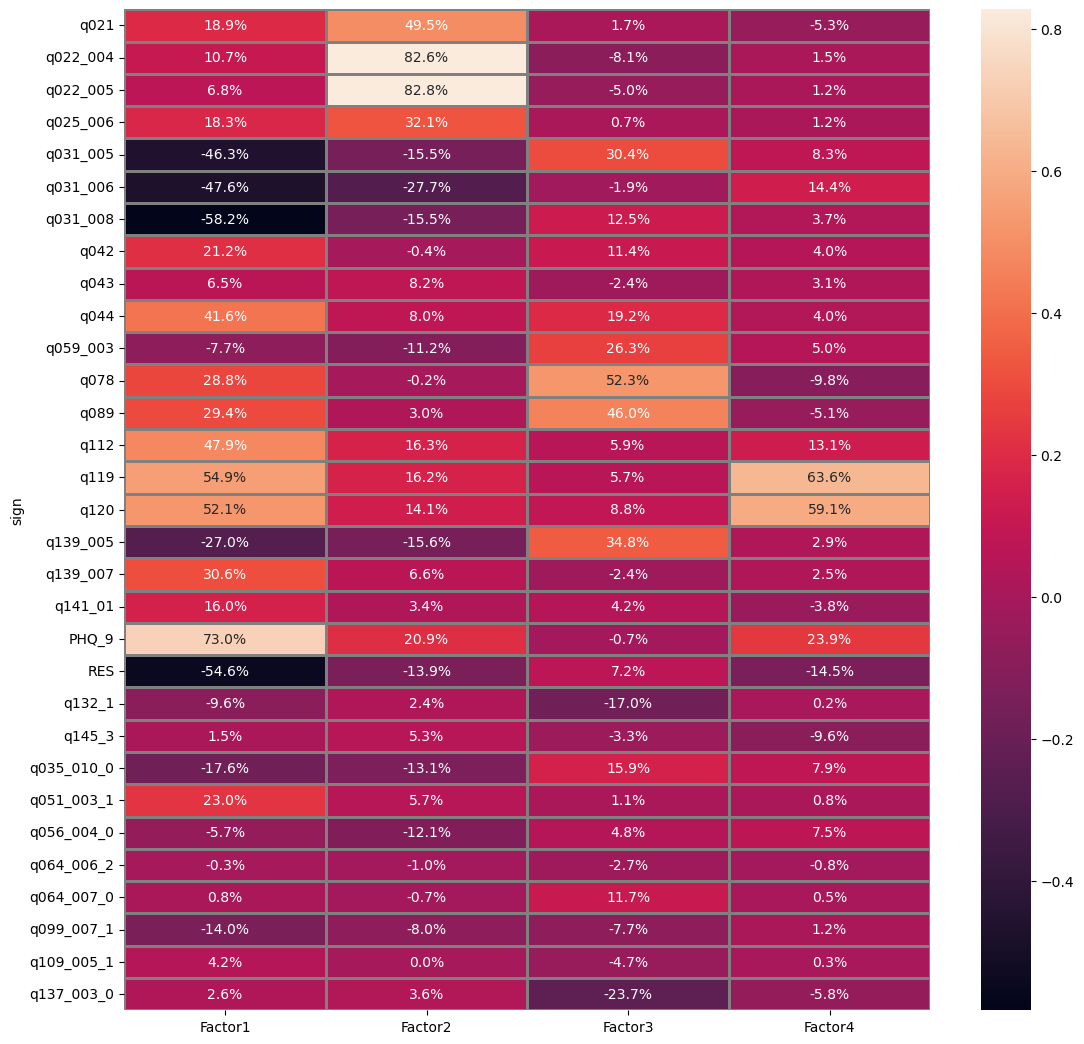

In [160]:
df_fa_pivot = (df_fa.pivot_table(index='sign')
               .sort_values(by=['№']).drop(columns=['№']))
plt.figure(figsize=(13, 13))
sns.heatmap(df_fa_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

In [237]:
df_no_methods_wo_open_comp = fillna_custom(df_no_methods_wo_open, df_no_methods_wo_open.columns)

In [239]:
df_no_methods_wo_open_comp

,q002,q003,q004,q005,q006,q007,q008,q009,q010,q011,...,SLEEP,OSSS,OSSScat,STRESS,STRESScat,alko,AUDIT,SF,Ind,average_time_sleep_dur
0,1.0,1.0,18.0,1.0,1.0,0.0,4.0,0.0,0.0,-1.0,...,12.0,8.0,0.0,7.0,0.0,2.0,-1.0,-1.0,1.0,7.0
1,0.0,0.0,20.0,3.0,1.0,0.0,4.0,0.0,0.0,-1.0,...,6.0,12.0,1.0,10.0,-1.0,2.0,0.0,0.0,0.0,7.0
2,1.0,-1.0,19.0,1.0,1.0,0.0,4.0,0.0,2.0,-1.0,...,7.0,9.0,2.0,10.0,2.0,3.0,-1.0,3.0,1.0,6.5
3,0.0,0.0,19.0,1.0,1.0,0.0,3.0,3.0,0.0,-1.0,...,6.0,11.0,2.0,11.0,2.0,2.0,0.0,1.0,1.0,7.0
4,1.0,0.0,24.0,3.0,1.0,0.0,3.0,0.0,0.0,-1.0,...,13.0,10.0,2.0,11.0,2.0,0.0,0.0,-1.0,1.0,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2078,0.0,0.0,19.0,1.0,1.0,0.0,4.0,7.0,5.0,-1.0,...,9.0,8.0,0.0,7.0,0.0,2.0,-1.0,0.0,1.0,6.0
2079,0.0,0.0,19.0,1.0,1.0,0.0,4.0,7.0,0.0,-1.0,...,5.0,8.0,0.0,10.0,2.0,2.0,-1.0,3.0,0.0,5.5
2080,2.0,0.0,23.0,4.0,1.0,1.0,4.0,7.0,2.0,-1.0,...,5.0,7.0,0.0,12.0,2.0,3.0,1.0,2.0,0.0,7.0
2081,1.0,1.0,22.0,1.0,1.0,0.0,3.0,7.0,6.0,-1.0,...,12.0,8.0,0.0,6.0,0.0,2.0,0.0,3.0,1.0,4.0


In [243]:
threshold = 0.5 * len(df_no_methods_wo_open)  # 50% от размера выборки

# Вычисление количества пропусков в каждом столбце
missing_counts = df_no_methods_wo_open.isnull().sum()
columns_to_drop = missing_counts[missing_counts > threshold].index

print(columns_to_drop)
df_no_methods_wo_open_comp = df_no_methods_wo_open.drop(columns=columns_to_drop)


missing_in_clean = df_no_methods_wo_open_comp.isnull().sum()
missing_in_clean_only = missing_in_clean[missing_in_clean > 0]

columns_to_fill = missing_in_clean_only.index
df_no_methods_wo_open_comp_clean = fillna_custom(df_no_methods_wo_open_comp, columns_to_fill)

Index([], dtype='object')


In [245]:
df_cyber = df_no_methods_wo_open_comp_clean[df_no_methods_wo_open_comp_clean['q126'] == 1]
df_not = df_no_methods_wo_open_comp_clean[df_no_methods_wo_open_comp_clean['q126'] == 2]

In [257]:
for l in num_comp:
    print(f'check l = {l}')
    u_c = U(df_cyber[l], df_not[l])
    if u_c.pvalue < 0.05:
        mean_cy, mean_not = df_cyber[l].mean(), df_not[l].mean()
        print(f'U-критерий равен: {u_c}')
        print(f'Средние значения данных групп равны: {mean_cy} (используют), {mean_not} (нет)')

check l = q012
check l = q021
check l = q022_001
check l = q022_002
U-критерий равен: MannwhitneyuResult(statistic=521730.5, pvalue=0.03725082652065028)
Средние значения данных групп равны: 1.8037889039242219 (используют), 1.7194940476190477 (нет)
check l = q022_003
check l = q022_004
check l = q022_005
check l = q023_001
U-критерий равен: MannwhitneyuResult(statistic=463720.5, pvalue=0.008458634965285147)
Средние значения данных групп равны: 3.810554803788904 (используют), 3.9404761904761907 (нет)
check l = q023_002
check l = q023_003
U-критерий равен: MannwhitneyuResult(statistic=569785.5, pvalue=1.0745691074526553e-08)
Средние значения данных групп равны: 2.9336941813261164 (используют), 2.5632440476190474 (нет)
check l = q023_004
check l = q025_001
check l = q025_002
check l = q025_003
U-критерий равен: MannwhitneyuResult(statistic=465323.5, pvalue=0.012938600116421756)
Средние значения данных групп равны: 2.7036535859269284 (используют), 2.8132440476190474 (нет)
check l = q025_004

In [1039]:
for l in other_cor:
    print(f'check l = {l}')
    u_c = U(df_cyber[l], df_not[l])
    if u_c.pvalue < 0.05:
        mean_cy, mean_not = df_cyber[l].mean(), df_not[l].mean()
        print(f'U-критерий равен: {u_c}')
        print(f'Средние значения данных групп равны: {mean_cy} (используют), {mean_not} (нет)')

check l = q004
check l = q028
check l = q040_001
check l = q040_002
check l = q040_003
check l = q040_004
U-критерий равен: MannwhitneyuResult(statistic=534885.5, pvalue=0.0003208391667535787)
Средние значения данных групп равны: 2.5 (используют), 1.8865327380952381 (нет)
check l = q079
check l = q090
check l = q096
check l = q103
check l = q118_01
check l = q118_02
check l = q133
check l = PHQ_9
U-критерий равен: MannwhitneyuResult(statistic=617367.5, pvalue=3.3761887030502164e-20)
Средние значения данных групп равны: 11.077131258457374 (используют), 8.463541666666666 (нет)
check l = RES
U-критерий равен: MannwhitneyuResult(statistic=415441.5, pvalue=5.91228579454862e-10)
Средние значения данных групп равны: 18.576454668470905 (используют), 19.913690476190474 (нет)
check l = SAMEF
U-критерий равен: MannwhitneyuResult(statistic=436177.0, pvalue=4.051368393404005e-06)
Средние значения данных групп равны: 28.884979702300406 (используют), 30.25 (нет)
check l = SLEEP
U-критерий равен: Mann

In [446]:

df_cyber['q031_011'].mean(), df_not['q031_011'].mean()

(2.814614343707713, 3.163660165745082)